In [102]:
import pandas as pd
import seaborn as sb
import numpy as nump
import statsmodels.formula.api as sm
import matplotlib.pyplot as plot
import nltk
import re
import unicodedata
import warnings
import matplotlib.pyplot as plt
import numpy as np

from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
from contraction_map import CONTRACTION_MAP
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

nltk.download('punkt')  # Ensure the tokenizer is available
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/issaennab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/issaennab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/issaennab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Data Source and Initial Viewing**

- Setting Display Options
- Loading and Displaying the Dataset

In [39]:
# Set display options
pd.set_option('display.max_columns', None)  # Ensure all columns are shown
pd.set_option('display.width', 1000)  # Adjust the width to fit your screen

AllDataTrain = pd.read_csv("drugsComTrain_raw.tsv", sep = "\t")
print(str(AllDataTrain.head(10)))

   Unnamed: 0                            drugName                     condition                                             review  rating               date  usefulCount
0      206461                           Valsartan  Left Ventricular Dysfunction  "It has no side effect, I take it in combinati...     9.0       May 20, 2012           27
1       95260                          Guanfacine                          ADHD  "My son is halfway through his fourth week of ...     8.0     April 27, 2010          192
2       92703                              Lybrel                 Birth Control  "I used to take another oral contraceptive, wh...     5.0  December 14, 2009           17
3      138000                          Ortho Evra                 Birth Control  "This is my first time using any form of birth...     8.0   November 3, 2015           10
4       35696            Buprenorphine / naloxone             Opiate Dependence  "Suboxone has completely turned my life around...     9.0  Novem

## Data Preparation and Cleaning Overview

### Inspect the Data
- **Objective:** Understand the dataset's structure, identify missing values, and assess text data quality.

### Handling Missing Values
- **Strategies:** Discuss the choice between removing rows or filling in missing values, highlighting the selected approach and its rationale.

### Text Normalization
- **Steps Taken:** List normalization techniques applied, such as lowercasing, removing HTML tags, and lemmatization.

### Removing Irrelevant Features
- **Justification:** Explain the criteria for feature selection and the impact on model performance and interpretability.

In [38]:
missing_values_summary = AllDataTrain.isnull().sum()
print("Missing Values Summary:\n")
max_column_width = max(len(column) for column in missing_values_summary.index)
for column, missing_count in missing_values_summary.items():
    print(f"{column.ljust(max_column_width)} : {missing_count} missing value(s)")


Missing Values Summary:

Unnamed: 0  : 0 missing value(s)
drugName    : 0 missing value(s)
condition   : 899 missing value(s)
review      : 0 missing value(s)
rating      : 0 missing value(s)
date        : 0 missing value(s)
usefulCount : 0 missing value(s)


he summary of missing values above indicates that the **condition** column is the only one with missing data, tallying 899 missing values. This finding is significant because the **condition** column likely plays a crucial role in our analysis, serving as a key variable for understanding the context of drug reviews.

Given this insight, our next steps in cleaning the dataset will thoughtfully address these missing **condition** values. Our aim is to preserve as much information as possible, thereby maintaining the integrity and usefulness of our data for analysis. We will consider the overall impact of missing data on our dataset and analysis goals. This includes evaluating different strategies, such as removing rows with missing **condition** values or possibly filling these gaps with a placeholder value like "Unknown". By considering various approaches to handle these missing values, we will ensure our dataset is as robust and representative as possible for the subsequent stages of our project.

Filling Missing Values with "Unknown"
In data analysis and machine learning, handling missing values is a critical preprocessing step. Missing data can occur for various reasons, such as errors during data collection, entry, or processing. The way we handle these missing values can significantly impact the results of our analysis.

For this project, we've encountered missing values in the **condition** column of our dataset. After considering the available strategies for dealing with missing data, we've decided to fill these missing values with the placeholder "Unknown". This decision is based on several key considerations:

- Data Preservation: By filling missing values with "Unknown", we retain all observations in our dataset. This is particularly important in our context because every review provides valuable insights that contribute to the overall analysis. Removing entries with missing **condition** data would reduce our dataset's size and potentially omit significant information.

- Analytical Clarity: Using a clear placeholder like "Unknown" allows us to maintain analytical clarity. It explicitly acknowledges the presence of missing information without making assumptions about the data. This approach ensures that our analysis remains transparent and reproducible.

- Flexibility in Analysis: Filling missing values with "Unknown" offers flexibility in our analysis. It enables us to include these entries in our analysis, which might reveal patterns related to missing data or differences between reviews with known and unknown **condition**.

- Practicality: This method is straightforward to implement and interpret. It avoids the complexities and potential biases of imputation methods, which might infer missing values based on other data. While imputation can be valuable, it may not always be appropriate, especially when the reasons for the missing data are not well understood.

- Real-World Application: In real-world scenarios, not all information is always available. By using "Unknown" for missing values, we mirror these situations, enhancing the practical relevance of our analysis. It prepares us to deal with incompleteness in data, a common challenge in data science.

In [60]:
# Fill missing 'condition' values with 'Unknown'
AllDataTrain['condition'] = AllDataTrain['condition'].fillna('Unknown')

# Suppress specific BeautifulSoup warning
warnings.filterwarnings('ignore', category=MarkupResemblesLocatorWarning)

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        expanded_contraction = contraction_mapping.get(match.lower(), match)  # Default to match if not found
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text

# Clean text data in 'review'
def clean_text(text):
    # Explicitly convert text to a string to avoid MarkupResemblesLocatorWarning
    text = str(text)
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove special characters
    text = text.lower()  # Lowercase the text
    return text

AllDataTrain['cleaned_review'] = AllDataTrain['review'].apply(clean_text)

pd.set_option('display.max_colwidth', 100)
# Display the first few rows to verify changes
print(AllDataTrain[['review', 'cleaned_review']].head(10))

                                                                                                review                                                                                       cleaned_review
0                      "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"                          it has no side effect i take it in combination of bystolic  mg and fish oil
1  "My son is halfway through his fourth week of Intuniv. We became concerned when he began this la...  my son is halfway through his fourth week of intuniv we became concerned when he began this last...
2  "I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very li...  i used to take another oral contraceptive which had  pill cycle and was very happy very light pe...
3  "This is my first time using any form of birth control. I&#039;m glad I went with the patch, I h...  this is my first time using any form of birth control im glad i went with the pa

In [61]:
# Display the original and cleaned review side by side for comparison for the first 5 records
for i in range(5):
    original_review = AllDataTrain.iloc[i]['review']
    cleaned_review = AllDataTrain.iloc[i]['cleaned_review']
    
    print(f"Record {i+1}")
    print(f"Original Review:\n{original_review}\n")
    print(f"Cleaned Review:\n{cleaned_review}\n")
    print("------------------------------------------------\n")

Record 1
Original Review:
"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"

Cleaned Review:
it has no side effect i take it in combination of bystolic  mg and fish oil

------------------------------------------------

Record 2
Original Review:
"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. 
We have tried many different medications and so far this is the 

In [63]:
# Example text
sample_text = "Here's an example of using NLTK's word_tokenize."

# Tokenize the text
tokens = word_tokenize(sample_text)

# Print the list of tokens
print(tokens)

['Here', "'s", 'an', 'example', 'of', 'using', 'NLTK', "'s", 'word_tokenize', '.']


**Here's a brief overview of each step:**

**Removing Accented Characters:** Normalizes and removes accents from characters, which can help standardize text input, especially if you're dealing with languages or datasets that include accented characters.

**Expanding Contractions:** Converts contracted forms like "can't" or "she's" to their expanded forms ("cannot", "she is"), which is beneficial for consistency and can improve the performance of subsequent NLP tasks.

In [74]:
def remove_accented_chars(text):
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    return text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        expanded_contraction = contraction_mapping.get(match.lower())
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text

**Lowercasing:** Converts all characters in the text to lowercase to ensure that the same words are recognized as identical regardless of their case in the original text (e.g., "The" and "the").

**Tokenizing:** Splits the text into individual words or tokens, which are the basic units for most NLP tasks.

**Removing Non-Alphabetic Characters:** Filters out tokens that do not contain alphabetic characters, which typically removes punctuation and special characters that may not be needed for analysis.

**Removing Stop Words:** Excludes common words (e.g., "and", "the", "is") that appear frequently in the language but usually don't carry significant meaning for analysis.

**Lemmatizing:** Reduces words to their base or dictionary form, helping to consolidate the different forms of a word into a single representation (e.g., "running" to "run").

In [75]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = remove_accented_chars(text)  # Removing accented characters
    text = expand_contractions(text)  # Expanding contractions
    text = text.lower()  # Converting to lowercase
    tokens = word_tokenize(text)  # Tokenizing the text
    tokens = [token for token in tokens if token.isalpha()]  # Removing non-alphabetic characters
    tokens = [token for token in tokens if token not in stop_words]  # Removing stop words
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatizing the tokens
    return tokens

In [78]:
AllDataTrain['processed_tokens'] = AllDataTrain['cleaned_review'].apply(preprocess_text)

# Display the first few rows of processed tokens to verify changes
print(AllDataTrain[['cleaned_review', 'processed_tokens']].head(10))

                                                                                        cleaned_review                                                                                     processed_tokens
0                          it has no side effect i take it in combination of bystolic  mg and fish oil                                           [side, effect, take, combination, bystolic, mg, fish, oil]
1  my son is halfway through his fourth week of intuniv we became concerned when he began this last...  [son, halfway, fourth, week, intuniv, became, concerned, began, last, week, started, taking, hig...
2  i used to take another oral contraceptive which had  pill cycle and was very happy very light pe...  [used, take, another, oral, contraceptive, pill, cycle, happy, light, period, max, day, side, ef...
3  this is my first time using any form of birth control im glad i went with the patch i have been ...  [first, time, using, form, birth, control, im, glad, went, patch, month, first, 

## Feature Extraction

### Bag of Words (BoW)
This method transforms text into fixed-length vectors by counting how many times each word appears in a document. While simple, BoW can be effective but doesn't account for the order of words and can result in sparse matrices with many dimensions.

### Term Frequency-Inverse Document Frequency (TF-IDF)
TF-IDF considers not only how often a word appears in a document (term frequency) but also how unique the word is across all documents (inverse document frequency). This helps to emphasize words that are important in a particular document but not common across all documents, potentially giving more meaningful features.

### Word Embeddings
Word embeddings are advanced techniques where words are represented as dense vectors in a continuous vector space. Methods like Word2Vec or GloVe learn to represent words based on their context, capturing semantic relationships between words. Pre-trained embeddings can be used directly, or you can train your own embeddings specific to your dataset.

In [85]:

# 'AllDataTrain['processed_text']' contains the cleaned and preprocessed text
# Join tokens into a single string for each document
AllDataTrain['processed_text'] = AllDataTrain['processed_tokens'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 features for simplicity

# Fit and transform the processed text to create TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(AllDataTrain['processed_text'])

# Prints the shape of the TF-IDF matrix
print(f"Shape of TF-IDF Matrix: {X_tfidf.shape}")

Shape of TF-IDF Matrix: (161297, 1000)


This output tells us that our dataset consists of **161,297 documents** (rows) and **1,000 features** (columns). Each feature corresponds to one of the top 1,000 terms considered most relevant across all documents, based on their TF-IDF scores.

### What Does This Mean?

**Dimensionality:** The process has effectively narrowed down the text data to the top 1,000 terms. This reduction in dimensionality helps make the dataset more manageable and computationally efficient for modeling, while still retaining the most informative aspects of the text.

**Readiness for Machine Learning Models:** The text data is now in a numerical format, enabling us to proceed with various machine learning models. Whether our goal is classification, clustering, or regression, the TF-IDF matrix serves as a suitable input for these models.

**Sparse Matrix Efficiency:** The X_tfidf matrix is a sparse matrix, meaning it primarily stores non-zero values. This is a memory-efficient way to handle text data, as typically, any given document will only contain a small subset of the overall vocabulary, resulting in a matrix where most values are zero.

## Model Selection

**Implement Logistic Regression as Baseline Model:** This step is part of the model selection phase but also includes training (fitting the model to the data) and evaluation (assessing its performance).

- **Split the Dataset**
- **Initialize and Train the Logistic Regression Model**
- **Make Predictions and Evaluate the Model**

In [87]:
y = AllDataTrain['rating']
X = X_tfidf

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model with max_iter value
lr_model = LogisticRegression(max_iter=1000)

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4159020458772474

Classification Report:
               precision    recall  f1-score   support

         1.0       0.44      0.70      0.54      4273
         2.0       0.17      0.03      0.05      1375
         3.0       0.21      0.05      0.08      1343
         4.0       0.17      0.03      0.05       970
         5.0       0.17      0.07      0.10      1623
         6.0       0.19      0.03      0.05      1331
         7.0       0.18      0.05      0.07      1945
         8.0       0.23      0.16      0.19      3754
         9.0       0.29      0.19      0.23      5408
        10.0       0.49      0.82      0.61     10238

    accuracy                           0.42     32260
   macro avg       0.25      0.21      0.20     32260
weighted avg       0.34      0.42      0.35     32260



In [93]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 6.4299798093208524
R-squared (R²): 0.3966021272991782


In [89]:
# Initialize the model using Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest R-squared (R²): {r2_rf}")

Random Forest Mean Squared Error (MSE): 4.327069377542827
Random Forest R-squared (R²): 0.5939420441642127


- **Random Forest Mean Squared Error (MSE):** 4.327: This is an improvement from the MSE you got with Linear Regression (6.43), indicating that the RandomForest model is, on average, making closer predictions to the actual ratings. A lower MSE signifies that the model's predictions are more accurate.

- **Random Forest R-squared (R²):** 0.5939: This shows a significant improvement over the Linear Regression model's R² (0.3966), suggesting that around 59.39% of the variance in the rating is now being explained by the model, compared to 39.66% previously. An R² closer to 1 indicates a model that can better account for the variance in the data.

The improved performance metrics indicate that the RandomForestRegressor is more effective for this task than the simpler Linear Regression model. This isn't surprising, given Random Forest's ability to capture non-linear relationships in the data through the ensemble of decision trees, which is often crucial for complex tasks like predicting ratings based on text data.

In [95]:
import joblib

# Save the model to a file
joblib.dump(rf_model, 'random_forest_regressor.joblib')


# Load the model from the file
# loaded_rf_model = joblib.load('random_forest_regressor.joblib')

['random_forest_regressor.joblib']

## Feature Importances

In [96]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a pandas Series to view the top N features
importances_series = pd.Series(feature_importances, index=feature_names)

# Print the top 20 most important features
print(importances_series.nlargest(20))

worse       0.023394
year        0.022621
worst       0.020320
love        0.016606
horrible    0.014727
life        0.014495
great       0.013575
bleeding    0.011330
best        0.010822
never       0.010463
month       0.007874
work        0.007692
day         0.007656
amazing     0.007260
miracle     0.006914
side        0.006807
taking      0.006426
made        0.006260
took        0.006108
gained      0.005956
dtype: float64


The list of most important features according to the model includes words with both positive and negative connotations, such as "love", "great", "best", "amazing", "miracle" indicating positive reviews, and "worst", "horrible", "never", "worse" indicating negative reviews. This suggests that the model is effectively capturing key sentiment indicators from the text to predict ratings. The presence of words like "year", "month", "day", "bleeding", "side" might indicate the duration of treatment, side effects, or other aspects important to users' experiences.

In [97]:
print("Model Parameters:")
print(rf_model.get_params())

Model Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [98]:
# y_test and y_pred_rf are defined
sample_actual_vs_predicted = pd.DataFrame({
    'Actual Rating': y_test[:10].to_numpy(),
    'Predicted Rating': y_pred_rf[:10]
})
print(sample_actual_vs_predicted)

   Actual Rating  Predicted Rating
0           10.0              8.74
1           10.0              9.42
2            8.0              8.28
3            7.0              3.49
4           10.0              8.91
5            9.0              8.39
6           10.0              8.77
7           10.0              8.07
8            8.0              9.09
9           10.0              9.79


## Sample Predictions vs. Actual Ratings
The comparison between actual and predicted ratings for a sample of the test set shows that while the model generally trends in the right direction (e.g., higher actual ratings correspond to higher predicted ratings), there are discrepancies, such as a prediction of 3.49 for an actual rating of 7. This indicates areas where the model might be improved to more accurately capture the nuances of the review texts.

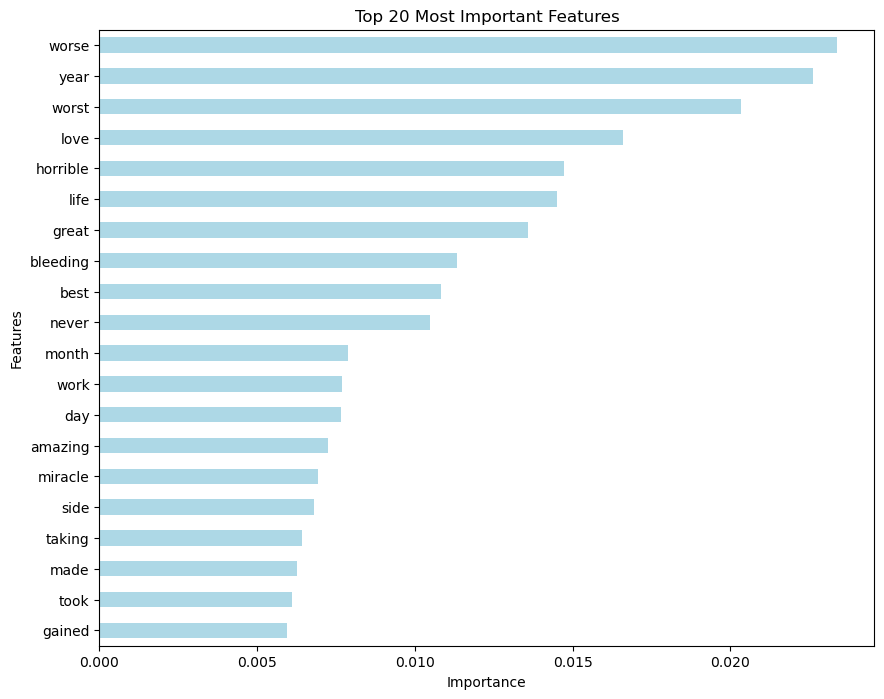

In [100]:
# Plot the top 20 most important features
top_n = importances_series.nlargest(20)
plt.figure(figsize=(10,8))
top_n.sort_values().plot(kind='barh', color='lightblue')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

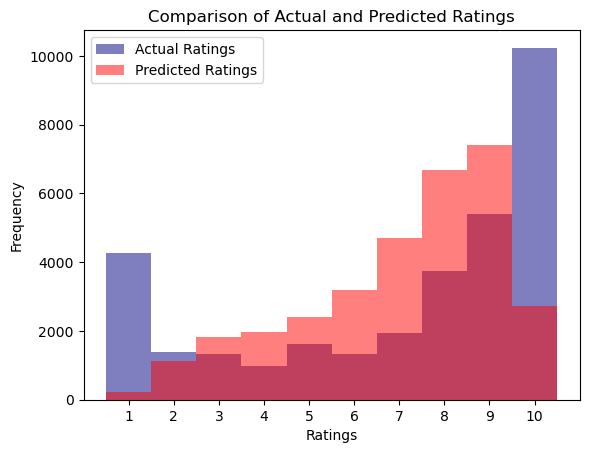

In [114]:
# Create a histogram of the actual ratings
plt.hist(y_test, bins=np.arange(1, 12) - 0.5, alpha=0.5, label='Actual Ratings', color='navy')

# Create a histogram of the predicted ratings
plt.hist(y_pred_rf, bins=np.arange(1, 12) - 0.5, alpha=0.5, label='Predicted Ratings', color='red')

# Add titles and labels
plt.title('Comparison of Actual and Predicted Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.xticks(range(1, 11))  # Set x-ticks to be the rating values
plt.legend()

# Show the plot
plt.show()

Here are some observations based on the plot:

**Central Tendency:** The predicted ratings appear to have a central tendency, clustering around the median of the scale, which is common in regression problems. The model may not be as confident in predicting the extreme values and thus gravitates towards the mean.

**High Ratings:** The model seems to underpredict the frequency of the highest rating (10), which is the most common actual rating based on the blue bars. It’s possible that the model is conservative with assigning the highest score unless the features strongly indicate such a rating.

**Model Calibration:** The differences between the heights of the bars suggest the model may benefit from calibration techniques that can adjust the distribution of the predicted probabilities (or in this case, predicted ratings) to better match the actual distribution.